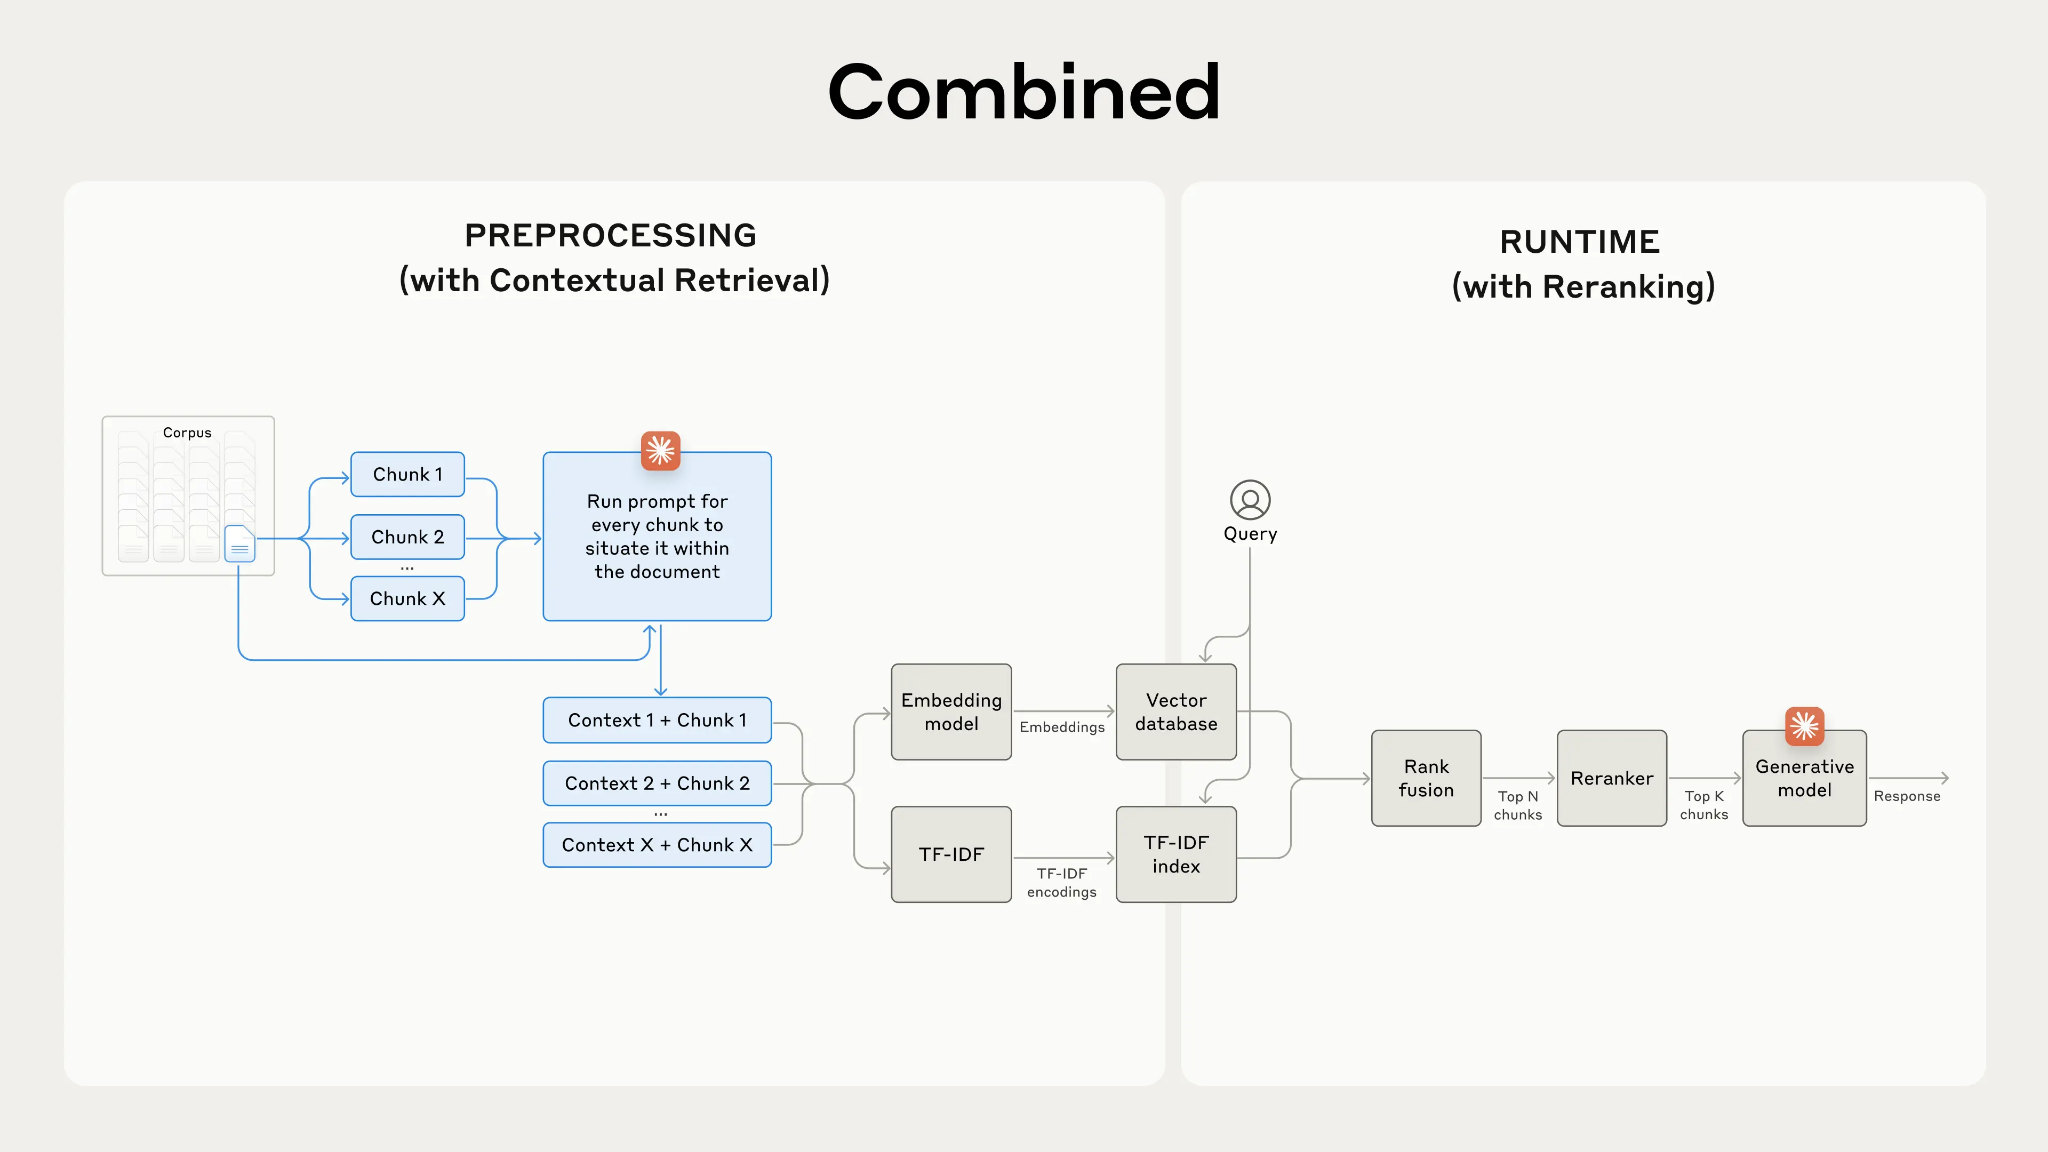

In [1]:
import os
os.environ["GROQ_API_KEY"] = "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"

In [2]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that understands the kql queries and understands them and explains them, this context will be given to a rag.",
        ),
        ("human", "{input}"),
    ]
)

chain = prompt | llm
chain.invoke(
    {
        "input": '''"let sourceMapping = dynamic(
                    {
                        ""Emergency Manager"" : ""Public"",
                        ""Utility Company"" : ""Private""
                    });
                    StormEvents
                    | where Source == ""Emergency Manager"" or Source == ""Utility Company""
                    | project EventId, Source, FriendlyName = sourceMapping[Source]"''',
    }
)

AIMessage(content='<think>\nOkay, so the user has given me a query where they want a short, succinct context to situate a code chunk within a larger document. The code provided is in Kusto Query Language (KQL), which I recognize is used for data analysis in Azure Data Explorer, among other tools. \n\nLooking at the code, I see that it\'s defining a dynamic mapping between Source values and their corresponding FriendlyName. The mapping is for "Emergency Manager" to "Public" and "Utility Company" to "Private". Then, it\'s querying a dataset called StormEvents, filtering where the Source is either of those two, and projecting the EventId, Source, and the FriendlyName using the mapping.\n\nI need to figure out the context. The code is about transforming data based on the Source field. It\'s likely part of a larger data processing or analysis task. The user wants this context to improve search retrieval, so the context should be clear and concise, making it easy for someone searching to fin

In [8]:
from remove_think import remove_think_tags
import pandas as pd

def send_kql_queries_with_context(csv_path: str):
    # 1. Read the CSV and check for the 'kql' column
    df = pd.read_csv(csv_path)
    if "kql" not in df.columns:
        raise ValueError("CSV does not contain a column named 'kql'.")

    # 2. Add a new column for context
    df["context"] = None

    # 3. Loop through each row, send the KQL query to the chain, and store the response as context
    for idx, row in df.iterrows():
        kql_query = row["kql"]
        print(f"Processing Row {idx}: {kql_query}")
        
        # Pass the KQL query as input to the chain
        response = remove_think_tags(chain.invoke({"input": kql_query}).content)
        
        # Store the response in the 'context' column
        df.at[idx, "context"] = response
        print(f"Response for Row {idx}:\n{response}\n{'-'*40}")

    # Save the updated DataFrame to a new CSV file
    updated_csv_path = r"C:\profolders\Internships\Inceptai\rag\dataset\kql_augmented.csv"
    df.to_csv(updated_csv_path, index=False)
    print(f"Updated CSV saved to {updated_csv_path}")

if __name__ == "__main__":
    # Replace 'my_data.csv' with the path to your CSV file.
    send_kql_queries_with_context(r"C:\profolders\Internships\Inceptai\rag\dataset\kql(Sheet1).csv")


Processing Row 0: StormEvents 
| count
Response for Row 0:


The KQL query "StormEvents | count" retrieves the total number of records in the StormEvents table. Here's a breakdown:

1. **StormEvents**: This is the name of the table being queried, which contains data about storm events.
2. **| (Pipe)**: This symbol passes the result of the table to the next command.
3. **count**: This function counts the number of rows in the table.

**Result**: The query returns the total count of all records in the StormEvents table, providing a quick overview of the dataset's size.
----------------------------------------
Processing Row 1: StormEvents
| take 5
| project State, EventType, DamageProperty
Response for Row 1:


The KQL query provided is designed to retrieve a specific subset of data from the StormEvents table. Here's a breakdown of the query and its implications:

1. **Dataset Selection**: The query accesses the "StormEvents" table, which contains records of storm events.

2. **Data Samp

In [ ]:
import os
import shutil
import pandas as pd
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer
import traceback

# Define the persistence directory path
persist_dir = "./chromadb_data"

# Delete the persistent directory if it exists to start fresh
if os.path.exists(persist_dir):
    shutil.rmtree(persist_dir)
    print(f"Cleared existing persistence directory: {persist_dir}")

# Set the environment variable for persistence
os.environ["CHROMA_DB_DIR"] = persist_dir

# Check if ChromaDB is installed properly
try:
    import chromadb
    use_chromadb = True
    print("ChromaDB imported successfully")
except ImportError as e:
    print(f"Warning: ChromaDB could not be imported. Error: {e}")
    use_chromadb = False

# Load the dataframe from the augmented CSV
try:
    df = pd.read_csv(r"C:\profolders\Internships\Inceptai\rag\dataset\kql_augmented.csv")
    print(f"Loaded {len(df)} rows from kql_augmented.csv")
    print(f"Columns in dataframe: {df.columns.tolist()}")
except Exception as e:
    print(f"Error loading CSV: {e}")
    traceback.print_exc()

# Initialize the embedding model
try:
    embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
    print("Embedding model loaded successfully")
except Exception as e:
    print(f"Error loading embedding model: {e}")
    traceback.print_exc()

# If ChromaDB is available, set it up using the new client configuration
if use_chromadb:
    try:
        chroma_client = chromadb.Client()
        collection = chroma_client.get_or_create_collection(name="kql_context_embeddings")
        print("ChromaDB collection created/accessed successfully")
    except Exception as e:
        print(f"Error setting up ChromaDB: {e}")
        traceback.print_exc()
        use_chromadb = False  # Fall back to alternative storage

# Define a function to process and store embeddings
def process_embeddings(df):
    if not use_chromadb:
        embeddings_data = []
    
    required_columns = ['context', 'kql']
    if not all(col in df.columns for col in required_columns):
        missing = [col for col in required_columns if col not in df.columns]
        print(f"Error: Missing required columns: {missing}")
        return
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing embeddings"):
        try:
            context = str(row['context']) if pd.notna(row['context']) else ""
            kql = str(row['kql']) if pd.notna(row['kql']) else ""
            combined_text = f"{context} {kql}".strip()
            
            if not combined_text:
                print(f"Warning: Empty text for row {idx}, skipping")
                continue
            
            embedding = embedding_model.encode(combined_text).tolist()
            
            if use_chromadb:
                collection.add(
                    documents=[combined_text],
                    metadatas=[{"row_id": str(idx)}],
                    ids=[f"row_{idx}"],
                    embeddings=[embedding]
                )
                # Log every 10 rows
                if idx % 10 == 0:
                    print(f"Embedding for Row {idx} stored in ChromaDB.")
            else:
                embeddings_data.append({
                    'row_id': idx,
                    'combined_text': combined_text,
                    'embedding': embedding
                })
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            traceback.print_exc()
    
    if not use_chromadb:
        try:
            embeddings_df = pd.DataFrame(embeddings_data)
            embeddings_df.to_pickle("embeddings_data.pkl")
            print("Embeddings saved to 'embeddings_data.pkl'")
        except Exception as e:
            print(f"Error saving embeddings: {e}")
            traceback.print_exc()

# Process embeddings: first test on a small subset then on the entire dataframe
print("Processing first 5 rows as a test...")
try:
    process_embeddings(df.head(5))
    print("Test successful!")
    
    # Clear the collection to avoid duplicate IDs when processing all rows
    if use_chromadb:
        chroma_client.delete_collection("kql_context_embeddings")
        collection = chroma_client.get_or_create_collection(name="kql_context_embeddings")
        print("ChromaDB collection reset for processing all rows.")
    
    print("Processing all rows...")
    process_embeddings(df)
except Exception as e:
    print(f"Error in processing: {e}")
    traceback.print_exc()


c:\profolders\Internships\Inceptai\rag\rag\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: The onnxruntime python package is not installed. Please install it with `pip install onnxruntime`

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Assuming `df` is already defined and contains the 'context' and 'kql' columns
# Combine 'context' and 'kql' columns to create a corpus
df = pd.read_csv(r"C:\profolders\Internships\Inceptai\rag\dataset\kql_augmented.csv")
corpus = df.apply(lambda row: f"{row['context']} {row['kql']}", axis=1)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the corpus to generate TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Convert the TF-IDF matrix to a DataFrame for better readability
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out(),
    index=df.index
)

# Save the TF-IDF DataFrame to a CSV file
tfidf_df.to_csv("tfidf_database.csv", index_label="RowIndex")
print("TF-IDF database saved to 'tfidf_database.csv'.")

TF-IDF database saved to 'tfidf_database.csv'.


In [7]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Part 2: Retrieval (Run in a new session) ---

# Load the vectorizer
with open("tfidf_vectorizer.pkl", "rb") as f:
    tfidf_vectorizer = pickle.load(f)
print("TF-IDF vectorizer loaded.")

# Load the original documents (if needed for display)
df_docs = pd.read_csv("original_documents.csv")
print("Original documents loaded.")

# Load the TF-IDF matrix CSV and convert back to a NumPy array
tfidf_df = pd.read_csv("tfidf_database.csv", index_col="RowIndex")
tfidf_matrix = tfidf_df.values
print("TF-IDF matrix loaded.")

def retrieve_similar_documents(query, top_k=5):
    # Convert the query to a TF-IDF vector using the loaded vectorizer
    query_vector = tfidf_vectorizer.transform([query])
    
    # Compute cosine similarity between the query vector and all document vectors
    similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
    
    # Get the indices of the top-k similar documents
    top_indices = similarities.argsort()[::-1][:top_k]
    
    # Retrieve the corresponding rows from the original dataframe and similarity scores
    results = df_docs.iloc[top_indices].copy()
    results["similarity"] = similarities[top_indices]
    return results

# Example usage:
user_query = "retrieve the total number of records in the StormEvents table"
results = retrieve_similar_documents(user_query, top_k=5)
print("Top similar entries found:")
print(results)


TF-IDF vectorizer loaded.
Original documents loaded.
TF-IDF matrix loaded.
Top similar entries found:
   Index                                                kql  \
0      0                              StormEvents \n| count   
1      1  StormEvents\n| take 5\n| project State, EventT...   
8      8  StormEvents\n| where State == 'TEXAS' and Even...   
2      2                 StormEvents \n| distinct EventType   
7      7  StormEvents\n| where State == 'TEXAS' and Even...   

                                             context  similarity  
0  \n\nThe KQL query "StormEvents | count" retrie...    0.611414  
1  \n\nThe KQL query provided is designed to retr...    0.344768  
8  \n\nThe KQL query is designed to retrieve the ...    0.308614  
2  \n\nThe KQL query "StormEvents | distinct Even...    0.303971  
7  \n\nThe KQL query is designed to retrieve the ...    0.286479  
